In [2]:
%reload_ext autoreload
%autoreload 2

from utils.utils import split_csv

from preprocessing.cleaning import get_cleaned_data
from preprocessing.encoding import encode_data

from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from exploration.midterm_exploration import plot_feature_against_diagnosis

from modeling.mrmr_feature_selection import plot_cutoffs
from modeling.logistic import run_elastic_net, evaluate_results
from modeling.RandomForest import run_random_forest, evaluate_random_forest
from modeling.mlp import run_mlp, evaluate_mlp
from modeling.comparisons import plot_f1_scores

## Constants for the label

In [3]:
LABEL = "P1_PT_TYPE"
AD = 1
CN = 2
MCI = 4

## Clean, encode, and partition the data into blood, clinical, and combined dataframes

In [4]:
df = encode_data(get_cleaned_data())
combined, blood_only, clinical_only_mci = split_csv(df)
clinical_only = clinical_only_mci[clinical_only_mci[LABEL] != MCI]

## Plot some initial exploratory visualizations

In [ ]:
plot_labels_pie_chart(df)

In [ ]:
plot_blood_draw_statistics(df)

In [ ]:
plot_correlations(df)

In [ ]:
plot_feature_against_diagnosis(
    blood_only,
    "Q1_Total_tau",
    title="Total Tau Concentration by Diagnosis",
    ylabel="Total Tau Concentration (pg/mL)",
    png="Total Tau Concentration by Diagnosis"
)

In [ ]:
plot_feature_against_diagnosis(
    clinical_only,
    "C1_WMSR_DIGTOT",
    title="WMSR Digit Span Score by Diagnosis",
    ylabel="WMSR Digit Span Score",
    png="WMSR Digit Span Score by Diagnosis"
)

## Run MRMR feature selection to pick features for each of the partitions

100%|██████████| 327/327 [00:05<00:00, 57.35it/s] 


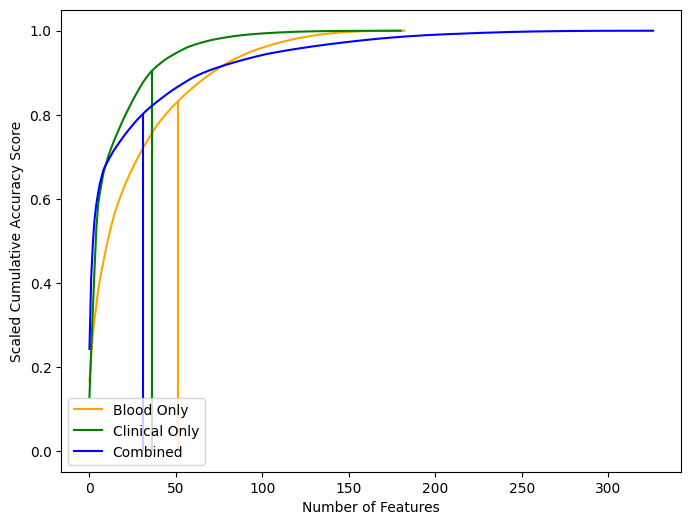

In [7]:
blood_features, clinical_features, combined_features = plot_cutoffs(blood_only, clinical_only, combined)
blood_only_subset = blood_only[blood_features + [LABEL]]
clinical_only_subset = clinical_only[clinical_features + [LABEL]]
combined_subset = combined[combined_features + [LABEL]]
clinical_only_subset_mci = clinical_only_mci[clinical_features + [LABEL]]

## Run logistic regression on the entire feature set

In [13]:
run_elastic_net(blood_only, num_iters=20, pickle="Blood Only LR")
blood_lr = evaluate_results("Blood Only LR")

Iteration 0
Best C: 0.1
Best l1 ratio: 0.4
Micro-F1 score: 0.8235294117647058
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e3/e4', 'APOE_GENOTYPE_e2/e3',
       'RBM_THPO', 'RBM_CTGF', 'RBM_MIP_1b', 'RBM_TNF_beta', 'RBM_SCF',
       'PROTEO_PYY', 'RBM_IGF_BP_2',
       ...
       'RBM_TSH', 'RBM_MPO', 'RBM_HGF', 'PROTEO_VEGF_D', 'PROTEO_LBP',
       'RBM_APO_A1', 'RBM_PARC', 'PROTEO_EOTAXIN_HUMAN', 'RBM_IgA', 'RBM_FAS'],
      dtype='object', length=192)
Confusion matrix:
[[53 10]
 [11 45]]

Iteration 1
Best C: 0.1
Best l1 ratio: 0.6
Micro-F1 score: 0.7815126050420168
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e2/e3', 'RBM_THPO',
       'APOE_GENOTYPE_e3/e4', 'RBM_CTGF', 'RBM_PP', 'RBM_Tenascin_C',
       'RBM_APO_A1', 'RBM_EN_RAGE', 'PROTEO_FLT_1',
       ...
       'PROTEO_TNF_A_HUMAN', 'RBM_TNF_beta', 'RBM_AXL', 'PROTEO_LBP',
       'RBM_MDC', 'RBM_ANG_2', 'RBM_PAI_1', 'RBM_MIP_1a', 'RBM_HGF',
       'PROTEO_VEGF_D'],
      dtype='object',

In [5]:
run_elastic_net(clinical_only, num_iters=20, pickle="Clinical Only LR")
clinical_lr = evaluate_results("Clinical Only LR")

Iteration 0
Best C: 1000.0
Best l1 ratio: 1
Micro-F1 score: 0.9702380952380952
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMSR_VRII',
       'C1_WMSR_LMEM1', 'C1_WMS3_VRI', 'A1_HISPANIC_1.0', 'C1_WMS3_LMEM2',
       'C1_SS_TRAILB', 'F1_PSMSTOTSCR',
       ...
       'B5_MOTSEV_2.0', 'B1_HEIGHT', 'C1_SS_TRAILA', 'A5_THYROID_1.0',
       'B1_WEIGHT', 'C1_CLOCK', 'B1_HEARING_1.0', 'C1_GDS30', 'B1_BMI',
       'C1_WAIS3_DIGTOT'],
      dtype='object', length=188)
Confusion matrix:
[[ 946   34]
 [  36 1336]]

Iteration 1
Best C: 10.0
Best l1 ratio: 1
Micro-F1 score: 0.9681122448979592
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMSR_VRII',
       'C1_WMS3_VRI', 'C1_SS_TRAILB', 'A1_HISPANIC_1.0', 'C1_WMS3_LMEM2',
       'B5_NPIQINF', 'F1_PSMSTOTSCR',
       ...
       'A3_PROP_PARENTS_DEM_0.5', 'A5_CVBYPASS_2.0', 'B1_HEIGHT',
       'A5_PACKSPER_2.0', 'A5_DIABETES_1.0', 'A5_TRAUMBRF_2.0',
       'B1_VISWCORR_1.0', 'B5

In [14]:
run_elastic_net(combined, num_iters=20, pickle="Combined LR")
combined_lr = evaluate_results("Combined LR")

Iteration 0
Best C: 1.0
Best l1 ratio: 0.4
Micro-F1 score: 0.9747899159663865
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'APOE_GENOTYPE_e3/e3', 'C1_WMS3_LMEM2',
       'C1_WMS3_LMEM1', 'B5_NPIQINF', 'RBM_PAI_1', 'C1_SS_TRAILA',
       'RBM_TRAIL_R3', 'RBM_VWF',
       ...
       'RBM_FAS', 'B5_ANXSEV_2.0', 'B5_DELSEV_2.0', 'A5_CVBYPASS_1.0',
       'A5_NUM_TIA', 'A5_DIABETES_1.0', 'C1_WMSR_LMEM1', 'C1_WMSR_DIGTOT',
       'A5_CVHATT_2.0', 'C1_WMSR_VRII'],
      dtype='object', length=380)
Confusion matrix:
[[56  2]
 [ 1 60]]

Iteration 1
Best C: 0.1
Best l1 ratio: 0.6
Micro-F1 score: 0.9411764705882353
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'APOE_GENOTYPE_e3/e3', 'C1_WMS3_LMEM2',
       'B5_NITESEV_1.0', 'B5_NPIQINF', 'APOE_GENOTYPE_e2/e3', 'AGE',
       'PROTEO_IL_15', 'B5_AGITSEV_1.0',
       ...
       'A5_HYPERCHO_2.0', 'A5_DIABETES_1.0', 'A5_DIABETES_2.0',
       'A5_B12DEF_1.0', 'RBM_TSH', 'C1_SS_TRAILA', 'B5_ANXSEV_2.0',
       'C1_WMS3_LM

## Run logistic regression on the features selected by MRMR

In [15]:
run_elastic_net(blood_only_subset, num_iters=20, pickle="Blood Only LR with MRMR")
blood_lr_mrmr = evaluate_results("Blood Only LR with MRMR")

Iteration 0
Best C: 0.1
Best l1 ratio: 0.8
Micro-F1 score: 0.8403361344537815
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e3/e4', 'APOE_GENOTYPE_e2/e3',
       'Q1_GFAP', 'PROTEO_PYY', 'RBM_G_CSF', 'RBM_TNF_beta', 'RBM_IGF_BP_2',
       'PROTEO_SVCAM_1', 'RBM_THPO', 'RBM_Factor_VII', 'RBM_S100b',
       'RBM_Tenascin_C', 'PROTEO_VEGF_D', 'RBM_ASP', 'RBM_PP', 'PROTEO_PIGF',
       'Q1_YKL_40', 'RBM_PAI_1', 'RBM_VWF', 'PROTEO_NT_PROBNP',
       'PROTEO_TOTAL_GIP', 'PROTEO_TARC_HUMAN', 'PROTEO_MPO',
       'PROTEO_IL_2_HUMAN', 'Q1_Quanterix_tp', 'PROTEO_IL_12_P40_HUMAN',
       'PROTEO_EOTAXIN_HUMAN', 'Q1_Quanterix_1.0', 'PROTEO_VEGF_ANGIO_PLATE',
       'PROTEO_GLUCAGON', 'RBM_Angiotensinogen', 'RBM_IL_15',
       'PROTEO_IL_6_HUMAN', 'RBM_PARC', 'RBM_Cortisol', 'PROTEO_TNF_A_HUMAN',
       'RBM_VCAM_1', 'PROTEO_ADIPONECTIN', 'RBM_IL_1ra', 'RBM_CRP',
       'RBM_CK_MB', 'RBM_MIP_1b', 'PROTEO_FLT_1', 'RBM_Alpha_2',
       'PROTEO_FABP3', 'RBM_IgE', 'RBM_VDBP', 'PROTE

In [8]:
run_elastic_net(clinical_only_subset, num_iters=20, pickle="Clinical Only LR with MRMR")
clinical_lr_mrmr = evaluate_results("Clinical Only LR with MRMR")

Iteration 0
Best C: 1.0
Best l1 ratio: 0
Micro-F1 score: 0.9566326530612245
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMS3_LMEM2', 'F1_PSMSTOTSCR', 'C1_WMS3_VRI',
       'A1_HISPANIC_1.0', 'C1_SS_TRAILB', 'B5_NPIQINF', 'C1_WMSR_LMEM2',
       'B5_DISNSEV_2.0', 'B5_IRRSEV_1.0', 'B5_APASEV_1.0', 'C1_WMSR_DIGTOT',
       'B5_NITESEV_2.0', 'A5_INCONTU_1.0', 'B5_DISNSEV_1.0', 'B5_IRRSEV_2.0',
       'B5_NITESEV_1.0', 'B5_APASEV_2.0', 'B1_BMI', 'A5_DEP2YRS_1.0',
       'B5_APASEV_3.0', 'C1_WAIS3_DIGTOT', 'D1_NEOPIF_3.0', 'B5_AGITSEV_2.0',
       'B5_ANXSEV_1.0', 'B5_APPSEV_2.0', 'AGE', 'B5_MOTSEV_2.0',
       'B5_AGITSEV_1.0', 'B5_MOTSEV_1.0', 'B5_DELSEV_1.0', 'B5_DEPDSEV_1.0',
       'B5_APPSEV_1.0', 'C1_SS_TRAILA', 'C1_WMS3_LMEM1', 'B5_ANXSEV_2.0'],
      dtype='object')
Confusion matrix:
[[ 921   69]
 [  33 1329]]

Iteration 1
Best C: 10.0
Best l1 ratio: 0.8
Micro-F1 score: 0.9604591836734694
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMS3_LMEM2', 'F1_PSMSTOTSCR', 'A1_HISPANI

In [16]:
run_elastic_net(combined_subset, num_iters=20, pickle="Combined LR with MRMR")
combined_lr_mrmr = evaluate_results("Combined LR with MRMR")

Iteration 0
Best C: 1.0
Best l1 ratio: 0.4
Micro-F1 score: 0.9411764705882353
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'C1_WMS3_LMEM2', 'C1_WMS3_VRI',
       'APOE_GENOTYPE_e2/e3', 'APOE_GENOTYPE_e3/e3', 'B5_ANXSEV_2.0',
       'RBM_TNF_beta', 'A5_INCONTU_1.0', 'AGE', 'C1_SS_TRAILA', 'C1_CLOCK',
       'B5_NITESEV_1.0', 'RBM_THPO', 'RBM_Tenascin_C', 'B5_DEPDSEV_1.0',
       'B5_APASEV_1.0', 'F2_IADLTOTSCR', 'B5_DISNSEV_1.0', 'B5_APPSEV_1.0',
       'B5_APASEV_2.0', 'B5_AGITSEV_1.0', 'PROTEO_PYY', 'PROTEO_EOTAXIN_HUMAN',
       'A5_DEP2YRS_1.0', 'C1_WMSR_VRII', 'B5_IRRSEV_2.0', 'D1_COGOTHIF_3.0',
       'C1_WMS3_LMEM1', 'C1_WAIS3_DIGTOT', 'RBM_PAI_1'],
      dtype='object')
Confusion matrix:
[[66  2]
 [ 5 46]]

Iteration 1
Best C: 0.1
Best l1 ratio: 0
Micro-F1 score: 0.9327731092436976
Feature importances: Index(['C1_SS_TRAILB', 'C1_WMSR_LMEM2', 'AGE', 'C1_WMS3_LMEM1',
       'C1_WMS3_LMEM2', 'F2_IADLTOTSCR', 'C1_SS_TRAILA', 'C1_CLOCK',
       'RBM_TNF_beta', 'C1_WMS

## Run random forest

In [17]:
run_random_forest(blood_only, num_iters=20, pickle="Blood Only RF", blood=True)
blood_rf = evaluate_random_forest("Blood Only RF")

Iteration 0
Micro-F1 score: 0.8487394957983193
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e2/e3', 'RBM_THPO',
       'PROTEO_RESISTIN', 'RBM_AgRP', 'RBM_TNF_beta', 'RBM_Tenascin_C',
       'RBM_Leptin', 'RBM_TNF_alpha', 'RBM_Myoglobin',
       ...
       'Q1_UCHL1', 'RBM_Adiponectin', 'RBM_CK_MB', 'RBM_IL_10', 'PROTEO_FABP3',
       'RBM_S100b', 'RBM_TBG', 'PROTEO_EOTAXIN_HUMAN', 'RBM_Insulin',
       'PROTEO_GLUCAGON'],
      dtype='object', length=192)
Confusion matrix:
[[46  4]
 [14 55]]

Iteration 1
Micro-F1 score: 0.8235294117647058
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e2/e3', 'RBM_THPO',
       'RBM_TNF_beta', 'PROTEO_PYY', 'RBM_CRP', 'RBM_RANTES',
       'PROTEO_RESISTIN', 'RBM_CD40L', 'RBM_HGF',
       ...
       'PROTEO_IFN_Y_HUMAN', 'RBM_CgA', 'RBM_CTGF', 'RBM_VCAM_1', 'RBM_FABP',
       'PROTEO_IP_10_HUMAN', 'PROTEO_LBP', 'PROTEO_PIGF', 'PROTEO_NT_PROBNP',
       'PROTEO_IL_6_HUMAN'],
      dtype='object', length=192)
Confu

In [9]:
run_random_forest(clinical_only, num_iters=20, pickle="Clinical Only RF")
clinical_rf = evaluate_random_forest("Clinical Only RF")

Iteration 0
Micro-F1 score: 0.9821428571428571
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_LMEM1', 'C1_WMS3_VRI', 'A1_HISPANIC_1.0',
       'C1_WMSR_VRI', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'C1_WAIS3_DIGTOT',
       'C1_WMSR_LMEM2', 'AGE',
       ...
       'B5_IRRSEV_1.0', 'A5_ARTHRITIC_1.0', 'A5_B12DEF_1.0', 'A5_TRAUMBRF_2.0',
       'B1_BPDIAS', 'A1_MARISTAT_3.0', 'B1_HRATE', 'B1_WEIGHT',
       'A5_INCONTU_1.0', 'A5_QUITSMOK'],
      dtype='object', length=188)
Confusion matrix:
[[ 949   25]
 [  17 1361]]

Iteration 1
Micro-F1 score: 0.9812925170068028
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM1', 'C1_WMS3_VRI',
       'C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'A1_HISPANIC_1.0', 'C1_WMSR_LMEM2',
       'F1_PSMSTOTSCR', 'C1_WAIS3_DIGTOT',
       ...
       'B1_VISION_1.0', 'A5_HYPERTEN_1.0', 'B5_AGITSEV_1.0', 'A5_QUITSMOK',
       'C1_WMSR_DIGTOT', 'B1_WEIGHT', 'A5_THYROID_1.0', 'C1_GDS30',
       'A5_TOBAC30_1.0', 'B1_BPSYS'],
      dtype='object', len

In [18]:
run_random_forest(combined, num_iters=20, pickle="Combined RF")
combined_rf = evaluate_random_forest("Combined RF")

Iteration 0
Micro-F1 score: 0.9663865546218487
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_LMEM1', 'C1_SS_TRAILB', 'C1_CLOCK',
       'C1_WMSR_LMEM2', 'APOE_GENOTYPE_e3/e3', 'C1_SS_TRAILA',
       'RBM_Tenascin_C', 'RBM_Sortilin', 'C1_WMS3_LMEM1',
       ...
       'A5_HYPERCHO_1.0', 'A5_HYPERCHO_2.0', 'A5_DIABETES_2.0',
       'A5_B12DEF_1.0', 'A5_B12DEF_2.0', 'A5_THYROID_1.0', 'A5_THYROID_2.0',
       'AGE', 'RBM_CRP', 'RBM_Eotaxin_3'],
      dtype='object', length=380)
Confusion matrix:
[[63  2]
 [ 2 52]]

Iteration 1
Micro-F1 score: 0.9327731092436976
Feature importances: Index(['F2_IADLTOTSCR', 'C1_SS_TRAILB', 'C1_WMSR_LMEM1', 'APOE_GENOTYPE_e3/e3',
       'C1_CLOCK', 'RBM_Progesterone', 'C1_WMSR_VRII', 'C1_WMSR_LMEM2',
       'RBM_Complement_3', 'RBM_CD40L',
       ...
       'RBM_IL_13', 'RBM_Alpha_2', 'Q1_NFL', 'RBM_Eotaxin_3', 'RBM_CEA',
       'RBM_SHBG', 'C1_GDS30', 'PROTEO_SAA', 'RBM_IL_8', 'AGE'],
      dtype='object', length=380)
Confusion matrix:
[[54  7]
 [ 1 

## Run MLP on the entire feature set

In [19]:
run_mlp(blood_only, num_iters=20, pickle="Blood Only MLP")
blood_mlp = evaluate_mlp("Blood Only MLP")

Iteration 0
Best Loss: 0.0033607271012097055
Best Validation Score: None
Micro-F1 score: 0.7647058823529412
Feature importances: Index(['RBM_TNF_beta', 'APOE_GENOTYPE_e3/e3', 'APOE_GENOTYPE_e2/e3',
       'RBM_Prolactin', 'PROTEO_PYY', 'RBM_CTGF', 'RBM_IL_5',
       'APOE_GENOTYPE_e4/e4', 'RBM_IGF_BP_2', 'RBM_MIP_1b',
       ...
       'Q1_Quanterix_tp', 'RBM_HB_EGF', 'PROTEO_TOTAL_GIP',
       'PROTEO_EOTAXIN_HUMAN', 'RBM_Ferritin', 'Q1_CD14', 'RBM_BDNF',
       'RBM_IL_15', 'RBM_FAS', 'RBM_Progesterone'],
      dtype='object', length=192)
Confusion matrix:
[[46 13]
 [15 45]]

Iteration 1
Best Loss: 0.004097615308147652
Best Validation Score: None
Micro-F1 score: 0.7563025210084033
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'RBM_TNF_beta', 'RBM_THPO',
       'APOE_GENOTYPE_e3/e4', 'APOE_GENOTYPE_e2/e3', 'RBM_IL_15', 'RBM_BDNF',
       'PROTEO_FACTOR_VII', 'PROTEO_EOTAXIN_HUMAN', 'PROTEO_LBP',
       ...
       'RBM_SCF', 'RBM_Insulin', 'RBM_GH', 'RBM_ENA_78', 'RBM_CRP',
      

In [10]:
run_mlp(clinical_only, num_iters=20, pickle="Clinical Only MLP")
clinical_mlp = evaluate_mlp("Clinical Only MLP")

Iteration 0
Best Loss: 0.00035915658492961144
Best Validation Score: None
Micro-F1 score: 0.9715136054421769
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMS3_LMEM2',
       'C1_WMS3_VRI', 'C1_WMSR_LMEM1', 'C1_WMSR_VRII', 'A1_HISPANIC_1.0',
       'C1_SS_TRAILB', 'F1_PSMSTOTSCR',
       ...
       'A5_TRAUMBRF_1.0', 'B1_HEARAID_1.0', 'A5_HYPERTEN_2.0', 'A5_B12DEF_2.0',
       'A5_SEIZURES_2.0', 'A1_MARISTAT_5.0', 'B5_NITESEV_2.0',
       'A5_PACKSPER_3.0', 'B1_VISWCORR_1.0', 'B1_VISION_1.0'],
      dtype='object', length=188)
Confusion matrix:
[[ 959   33]
 [  34 1326]]

Iteration 1
Best Loss: 0.00038070109778371526
Best Validation Score: None
Micro-F1 score: 0.9681122448979592
Feature importances: Index(['F2_IADLTOTSCR', 'C1_WMSR_VRI', 'C1_WMSR_LMEM2', 'C1_WMS3_VRI',
       'C1_WMSR_VRII', 'A1_HISPANIC_1.0', 'C1_WMS3_LMEM2', 'C1_WMSR_LMEM1',
       'C1_SS_TRAILB', 'F1_PSMSTOTSCR',
       ...
       'B5_APPSEV_1.0', 'A5_DIABETES_2.0', 'B1_VISION_1.0'

In [20]:
run_mlp(combined, num_iters=20, pickle="Combined MLP")
combined_mlp = evaluate_mlp("Combined MLP")

Iteration 0
Best Loss: 0.0033849272645665547
Best Validation Score: None
Micro-F1 score: 0.8907563025210086
Feature importances: Index(['C1_WMS3_LMEM2', 'APOE_GENOTYPE_e3/e3', 'RBM_THPO', 'A5_PACKSPER_5.0',
       'PROTEO_VEGF_D', 'C1_SS_TRAILA', 'A5_CVANGIO_1.0', 'C1_SS_TRAILB',
       'Q1_Total_tau', 'RBM_IL_15',
       ...
       'RBM_Prolactin', 'RBM_Progesterone', 'A5_B12DEF_1.0', 'RBM_IL_8',
       'RBM_sRAGE', 'A5_PSYCDIS_1.0', 'A5_TRAUMEXT_2.0', 'RBM_Insulin',
       'RBM_MMP_3', 'RBM_CK_MB'],
      dtype='object', length=380)
Confusion matrix:
[[52  8]
 [ 5 54]]

Iteration 1
Best Loss: 0.0025136979131326277
Best Validation Score: None
Micro-F1 score: 0.8991596638655462
Feature importances: Index(['C1_SS_TRAILA', 'APOE_GENOTYPE_e3/e3', 'F2_IADLTOTSCR', 'RBM_CgA',
       'RBM_SAP', 'RBM_TF', 'RBM_VWF', 'C1_SS_TRAILB', 'RBM_TIMP_1', 'RBM_HGF',
       ...
       'B1_HEARING_1.0', 'B1_HEARWAID_1.0', 'B1_HEARAID_1.0',
       'PROTEO_IL_12_P40_HUMAN', 'RBM_Prolactin', 'PROTEO_FLT_1',

## Run MLP on the features selected by MRMR

In [21]:
run_mlp(blood_only_subset, num_iters=20, pickle="Blood Only MLP with MRMR")
blood_mlp_mrmr = evaluate_mlp("Blood Only MLP with MRMR")

Iteration 0
Best Loss: 0.008380589492535454
Best Validation Score: None
Micro-F1 score: 0.8487394957983193
Feature importances: Index(['APOE_GENOTYPE_e3/e3', 'RBM_THPO', 'APOE_GENOTYPE_e2/e3',
       'APOE_GENOTYPE_e3/e4', 'RBM_TNF_beta', 'RBM_VCAM_1',
       'PROTEO_IL_12_P40_HUMAN', 'RBM_IL_1ra', 'PROTEO_SVCAM_1', 'RBM_VWF',
       'RBM_B2M', 'PROTEO_VEGF_D', 'PROTEO_IL_6_HUMAN', 'RBM_CK_MB',
       'Q1_Quanterix_1.0', 'RBM_Angiotensinogen', 'RBM_ASP', 'RBM_S100b',
       'RBM_MIP_1b', 'Q1_GFAP', 'RBM_G_CSF', 'PROTEO_FABP3', 'RBM_Cortisol',
       'Q1_YKL_40', 'Q1_Quanterix_tp', 'RBM_Tenascin_C', 'PROTEO_PYY',
       'APOE_GENOTYPE_e4/e4', 'PROTEO_EOTAXIN_HUMAN', 'RBM_PAI_1',
       'PROTEO_VEGF_ANGIO_PLATE', 'PROTEO_MCP_4_HUMAN', 'RBM_IL_15',
       'PROTEO_NT_PROBNP', 'PROTEO_TARC_HUMAN', 'PROTEO_MPO', 'RBM_Alpha_2',
       'PROTEO_FLT_1', 'PROTEO_GLUCAGON', 'PROTEO_TOTAL_GIP',
       'PROTEO_TNF_A_HUMAN', 'RBM_VDBP', 'PROTEO_PIGF', 'RBM_CRP',
       'RBM_IGF_BP_2', 'PROTEO_ADIPONE

In [11]:
run_mlp(clinical_only_subset, num_iters=20, pickle="Clinical Only MLP with MRMR")
clinical_mlp_mrmr = evaluate_mlp("Clinical Only MLP with MRMR")

Iteration 0
Best Loss: 0.02435944824380109
Best Validation Score: None
Micro-F1 score: 0.9719387755102041
Feature importances: Index(['F2_IADLTOTSCR', 'C1_SS_TRAILB', 'A1_HISPANIC_1.0', 'C1_WMS3_LMEM2',
       'C1_WMS3_VRI', 'B5_NPIQINF', 'C1_WMSR_LMEM2', 'F1_PSMSTOTSCR',
       'C1_WMS3_LMEM1', 'B5_MOTSEV_2.0', 'C1_SS_TRAILA', 'B5_DISNSEV_1.0',
       'B5_APASEV_1.0', 'C1_WAIS3_DIGTOT', 'B5_DISNSEV_2.0', 'B5_AGITSEV_1.0',
       'B5_IRRSEV_1.0', 'AGE', 'C1_WMSR_DIGTOT', 'B1_BMI', 'B5_AGITSEV_2.0',
       'A5_DEP2YRS_1.0', 'A5_INCONTU_1.0', 'B5_ANXSEV_2.0', 'B5_APASEV_2.0',
       'B5_APPSEV_2.0', 'B5_MOTSEV_1.0', 'B5_NITESEV_2.0', 'B5_IRRSEV_2.0',
       'D1_NEOPIF_3.0', 'B5_DELSEV_1.0', 'B5_NITESEV_1.0', 'B5_APASEV_3.0',
       'B5_APPSEV_1.0', 'B5_DEPDSEV_1.0', 'B5_ANXSEV_1.0'],
      dtype='object')
Confusion matrix:
[[ 939   36]
 [  30 1347]]

Iteration 1
Best Loss: 0.02050592606272855
Best Validation Score: None
Micro-F1 score: 0.9583333333333334
Feature importances: Index(['F2_I

In [22]:
run_mlp(combined_subset, num_iters=20, pickle="Combined MLP with MRMR")
combined_mlp_mrmr = evaluate_mlp("Combined MLP with MRMR")

Iteration 0
Best Loss: 0.005748147231493851
Best Validation Score: None
Micro-F1 score: 0.9411764705882353
Feature importances: Index(['C1_WMSR_LMEM2', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'B5_APASEV_1.0',
       'APOE_GENOTYPE_e2/e3', 'B5_NITESEV_1.0', 'F2_IADLTOTSCR',
       'C1_WMSR_VRII', 'APOE_GENOTYPE_e3/e3', 'RBM_Tenascin_C', 'RBM_THPO',
       'B5_AGITSEV_1.0', 'B5_DISNSEV_1.0', 'B5_APPSEV_1.0', 'C1_WAIS3_DIGTOT',
       'B5_IRRSEV_2.0', 'A5_DEP2YRS_1.0', 'D1_COGOTHIF_3.0', 'B5_ANXSEV_2.0',
       'RBM_PAI_1', 'PROTEO_PYY', 'RBM_TNF_beta', 'B5_DEPDSEV_1.0',
       'B5_APASEV_2.0', 'PROTEO_EOTAXIN_HUMAN', 'A5_INCONTU_1.0',
       'C1_WMS3_VRI', 'C1_SS_TRAILA', 'C1_WMS3_LMEM1', 'C1_CLOCK', 'AGE'],
      dtype='object')
Confusion matrix:
[[58  4]
 [ 3 54]]

Iteration 1
Best Loss: 0.008171704216902545
Best Validation Score: None
Micro-F1 score: 0.957983193277311
Feature importances: Index(['C1_WMSR_LMEM2', 'C1_SS_TRAILB', 'C1_WMS3_LMEM2', 'C1_CLOCK',
       'APOE_GENOTYPE_e3/e3', 'C1_W

## Compare models

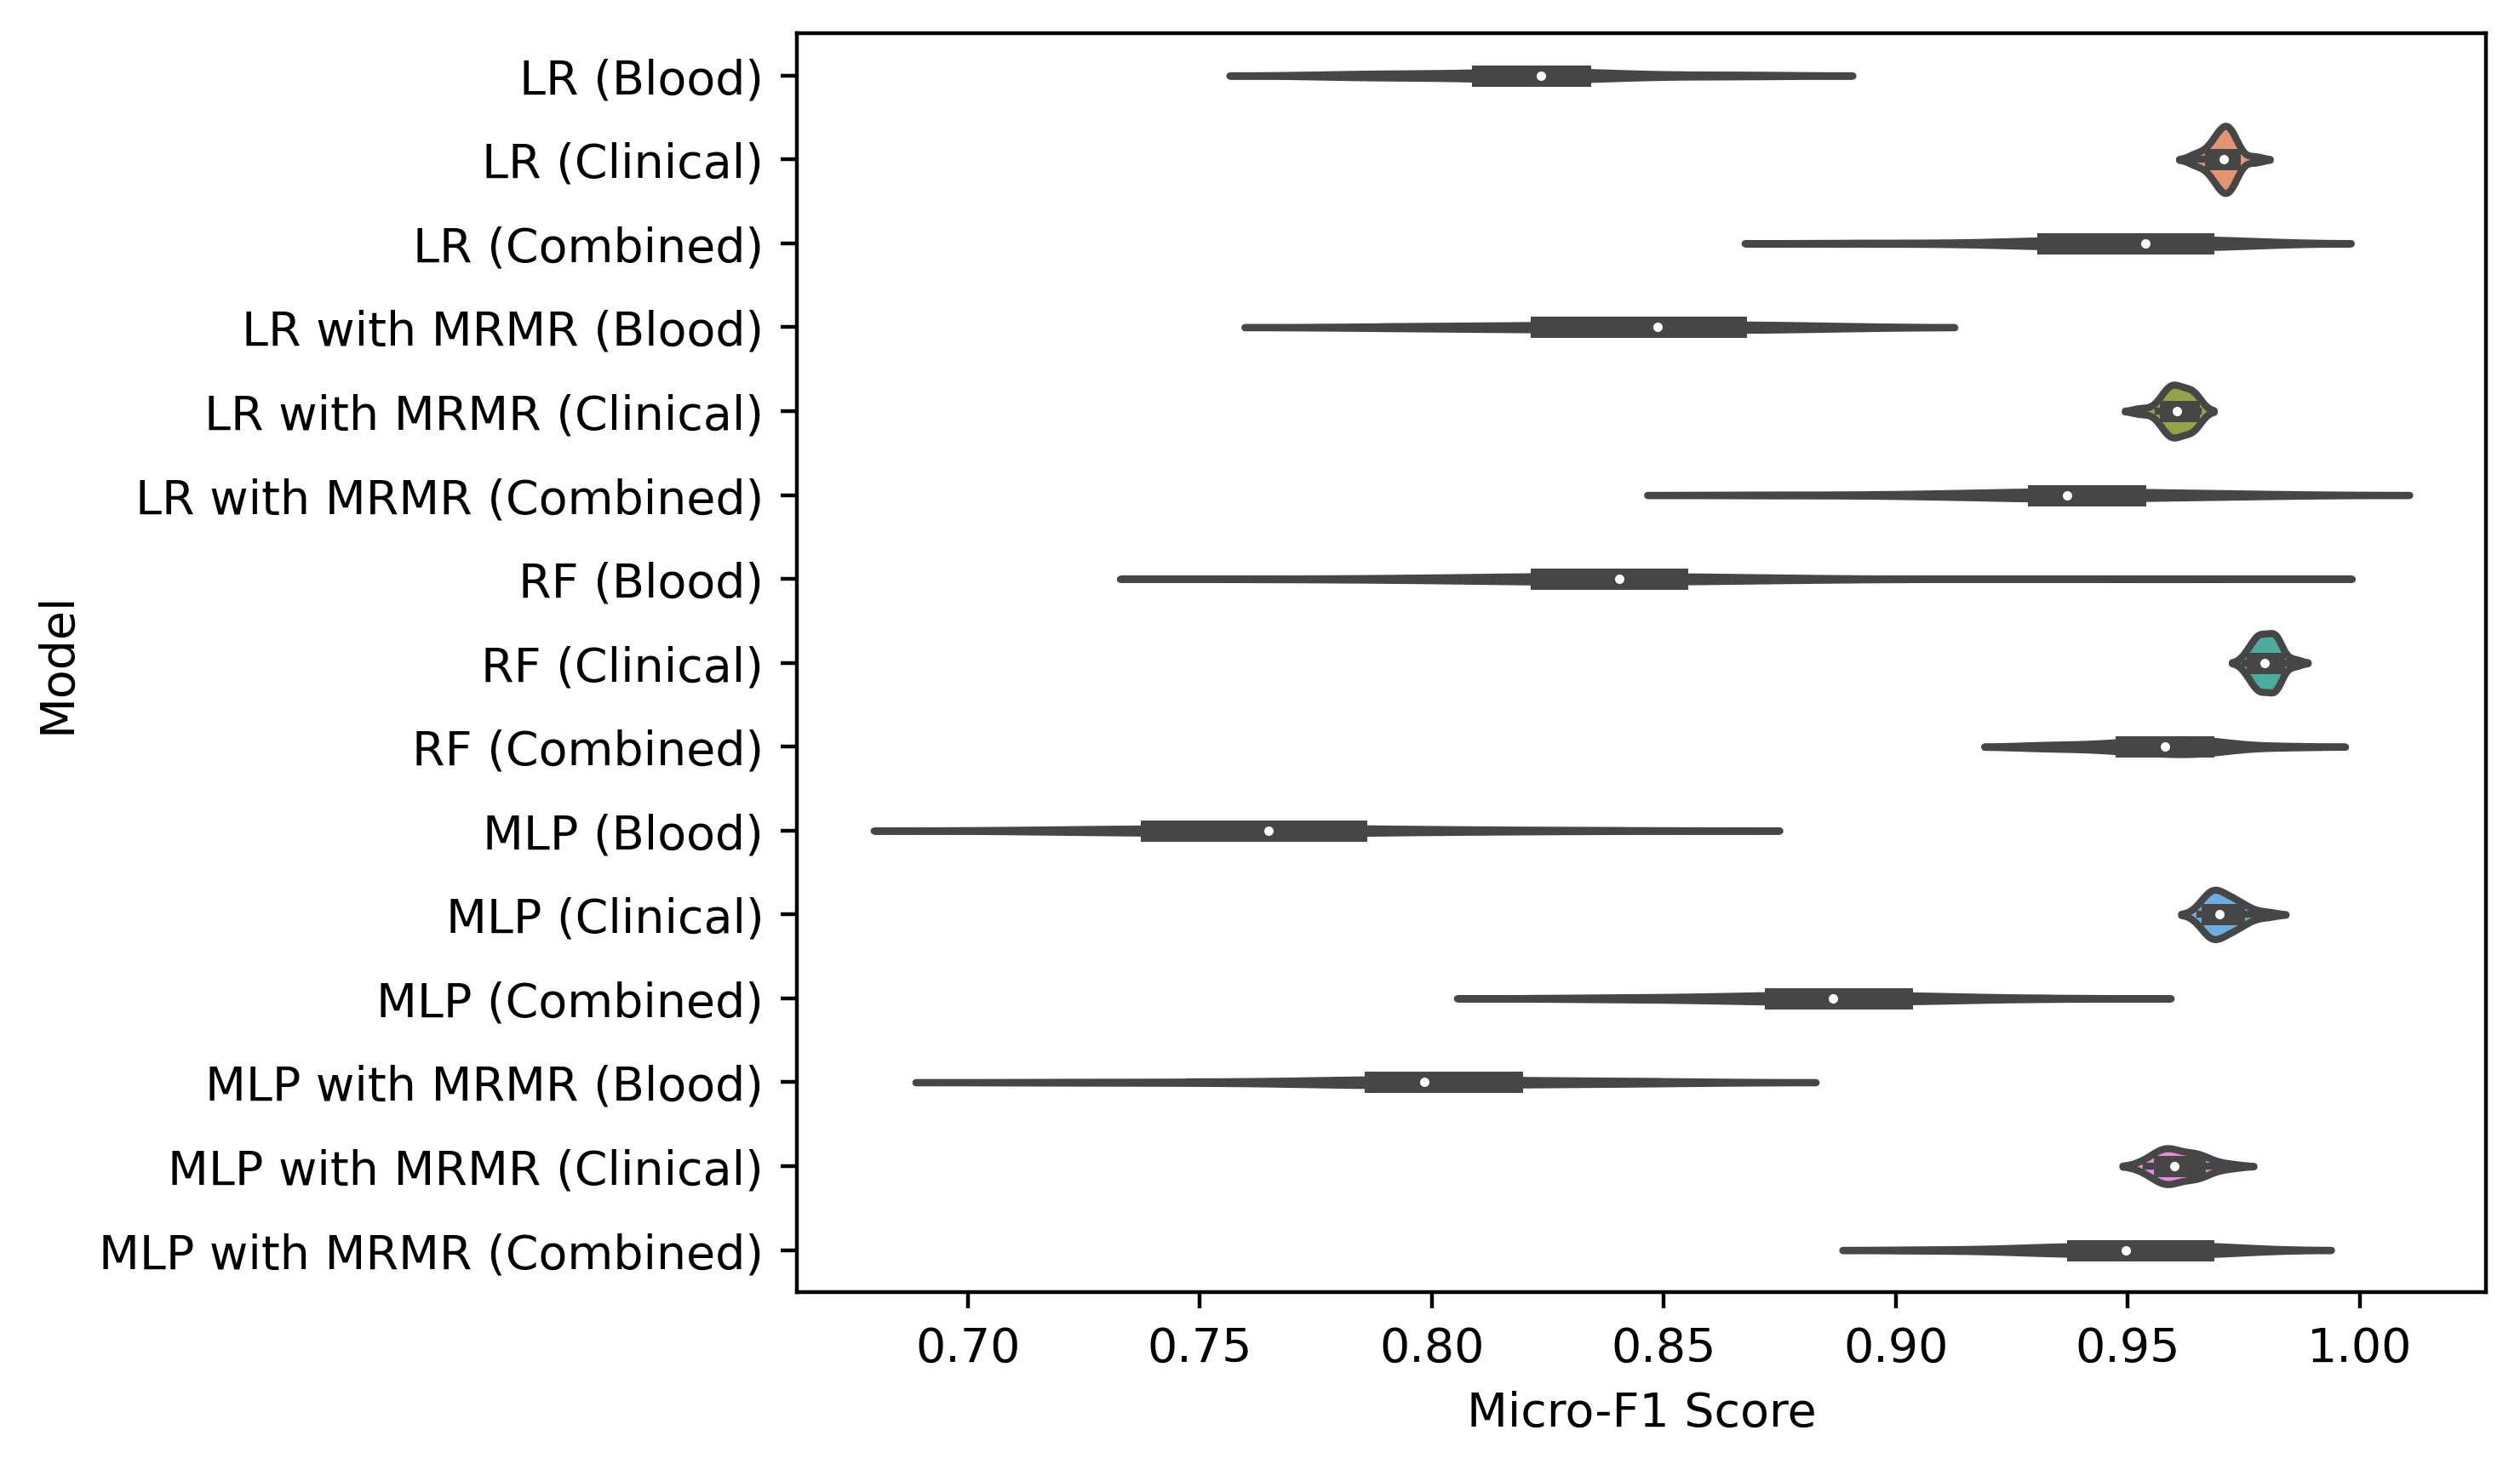

In [26]:
plot_f1_scores(
    [
        # Clinical stuff commented out due to time
        blood_lr["f1"],
        clinical_lr["f1"],
        combined_lr["f1"],
        blood_lr_mrmr["f1"],
        clinical_lr_mrmr["f1"],
        combined_lr_mrmr["f1"],
        blood_rf["f1"],
        clinical_rf["f1"],
        combined_rf["f1"],
        blood_mlp["f1"],
        clinical_mlp["f1"],
        combined_mlp["f1"],
        blood_mlp_mrmr["f1"],
        clinical_mlp_mrmr["f1"],
        combined_mlp_mrmr["f1"]
    ],
    xlabel="Micro-F1 Score",
    ylabel="Model",
    models=[
        "LR (Blood)",
        "LR (Clinical)",
        "LR (Combined)",
        "LR with MRMR (Blood)",
        "LR with MRMR (Clinical)",
        "LR with MRMR (Combined)",
        "RF (Blood)",
        "RF (Clinical)",
        "RF (Combined)",
        "MLP (Blood)",
        "MLP (Clinical)",
        "MLP (Combined)",
        "MLP with MRMR (Blood)",
        "MLP with MRMR (Clinical)",
        "MLP with MRMR (Combined)",
    ]
)

In [ ]:
run_elastic_net(clinical_only_mci, num_iters=20, pickle="Clinical LR with MCI")
clinical_lr_mci = evaluate_results("Clinical LR with MCI")

In [ ]:
run_elastic_net(clinical_only_subset_mci, num_iters=20, pickle="Clinical LR with MCI and MRMR")
clinical_lr_mci_mrmr = evaluate_results("Clinical LR with MCI and MRMR")